# Task1

In [20]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import pydot
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


In [21]:
#data preparation
df = pd.read_csv("database/car.csv")
#transfer all ? to nah
n=0
while n<df.shape[1]:
    if df[df.columns[n]].dtype == object:
        mask = df[df.columns[n]] =='?'
        df.loc[mask,df.columns[n]] = np.nan
    n+=1
#change USA to American
df['Nationality'].replace('USA','AMERICAN',inplace=True)
#fix IsOnlineSale
df['IsOnlineSale'] = df['IsOnlineSale'].astype(float)
mask = df['IsOnlineSale'] >=1
df.loc[mask,'IsOnlineSale'] = 1
mask = df['IsOnlineSale'] <=0
df.loc[mask,'IsOnlineSale'] = 0
#fix ForSale
mask = df['ForSale'] == 'YES' 
df.loc[mask,'ForSale'] = 'Yes'
mask = df['ForSale'] == 'yes' 
df.loc[mask,'ForSale'] = 'Yes'
mask = (df['ForSale'] == '0')
df.loc[mask,'ForSale'] = 'No'
#fix MMRCURRENTRETAILRATIO
mask = df['MMRCurrentRetailRatio'] =='#VALUE!'
df.loc[mask,'MMRCurrentRetailRatio'] = np.nan
#map binary value
PRIMEUNIT_map = {'NO':0, 'YES': 1}
df['PRIMEUNIT'] = df['PRIMEUNIT'].map(PRIMEUNIT_map)
ForSale_map = {'No':0, 'Yes': 1}
df['ForSale'] = df['ForSale'].map(ForSale_map)
AUCGUART_map = {'RED':0, 'GREEN':1}
df['AUCGUART'] = df['AUCGUART'].map(AUCGUART_map)
#drop value
df.drop(['PurchaseID','PurchaseTimestamp','PurchaseDate','WheelTypeID'],axis=1,inplace=True)
#convert MMR values and VehBCost from object to float
for n in range(10,19):
    df[df.columns[n]] = df[df.columns[n]].astype(float)
df['VehBCost'] = df['VehBCost'].astype(float)
#fix all the values
for k in df:
    if df[k].isna().any():
        if df[k].dtypes == 'object':
            df[k] = df[k].fillna('Unknown')
        else:
            df[k] = df[k].fillna(df[k].mean())
#for all MMR values,replace all the outlier with mean
for m in range(10,18):
    mask = df[df.columns[m]] < 500
    df.loc[mask,df.columns[m]] = df[df.columns[m]].mean()
#get dummies
df = pd.get_dummies(df)

In [22]:
print("After:", len(df.columns))

After: 133


### 1. What is the proportion of cars who can be classified as a “kick”?

In [4]:
print('The proportion of cars who can be classified as a kick: ', len( df[df['IsBadBuy'] == 1 ])/df.shape[0])

The proportion of cars who can be classified as a kick:  0.1294965763333012


### 2. Did you have to fix any data quality problems? Detail them.

* transfer all '?' and '#value' to nah
* change USA to American becuase they are same
* change IsOnlineSale,Forsale,PRIMEUNIT,AUCGUART from object to binary
* drop useless value
* fix all the value type
* replace nan to mean value on float value
* replace nan to unknown on object value
* one hot implementation of categorical value

### 3. Can you identify any clear patterns by initial exploration of the data using histogram or box plot?

In [13]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 27 columns):
Auction                              41476 non-null object
VehYear                              41476 non-null float64
Make                                 41476 non-null object
Color                                41476 non-null object
Transmission                         41476 non-null object
WheelType                            41476 non-null object
VehOdo                               41476 non-null float64
Nationality                          41476 non-null object
Size                                 41476 non-null object
TopThreeAmericanName                 41476 non-null object
MMRAcquisitionAuctionAveragePrice    41476 non-null float64
MMRAcquisitionAuctionCleanPrice      41476 non-null float64
MMRAcquisitionRetailAveragePrice     41476 non-null float64
MMRAcquisitonRetailCleanPrice        41476 non-null float64
MMRCurrentAuctionAveragePrice        41476 non-null float64

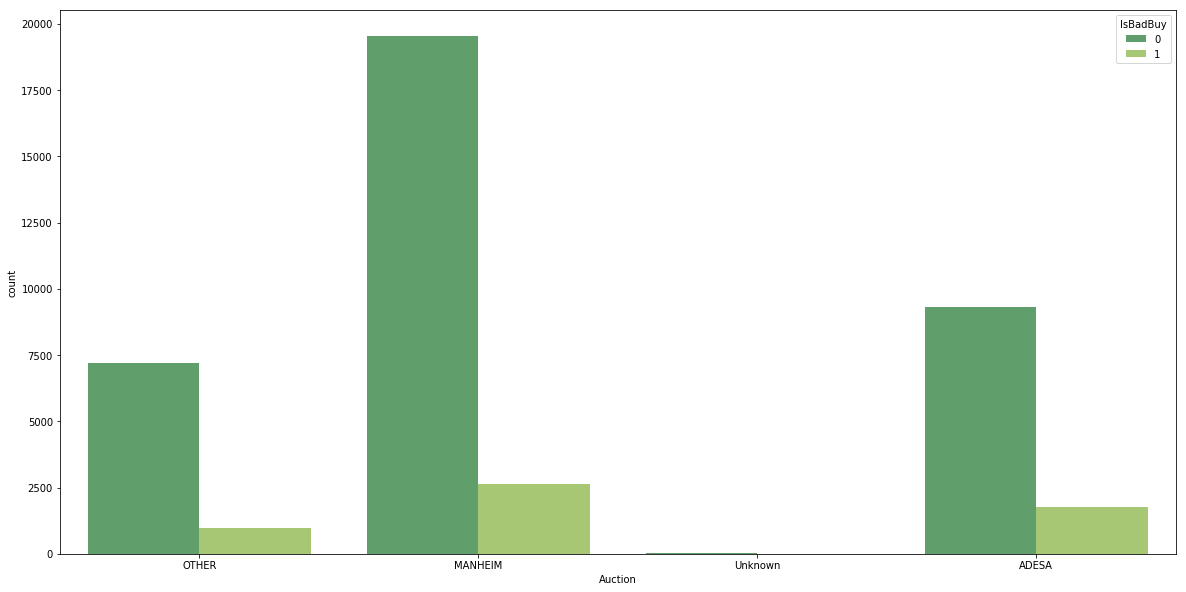

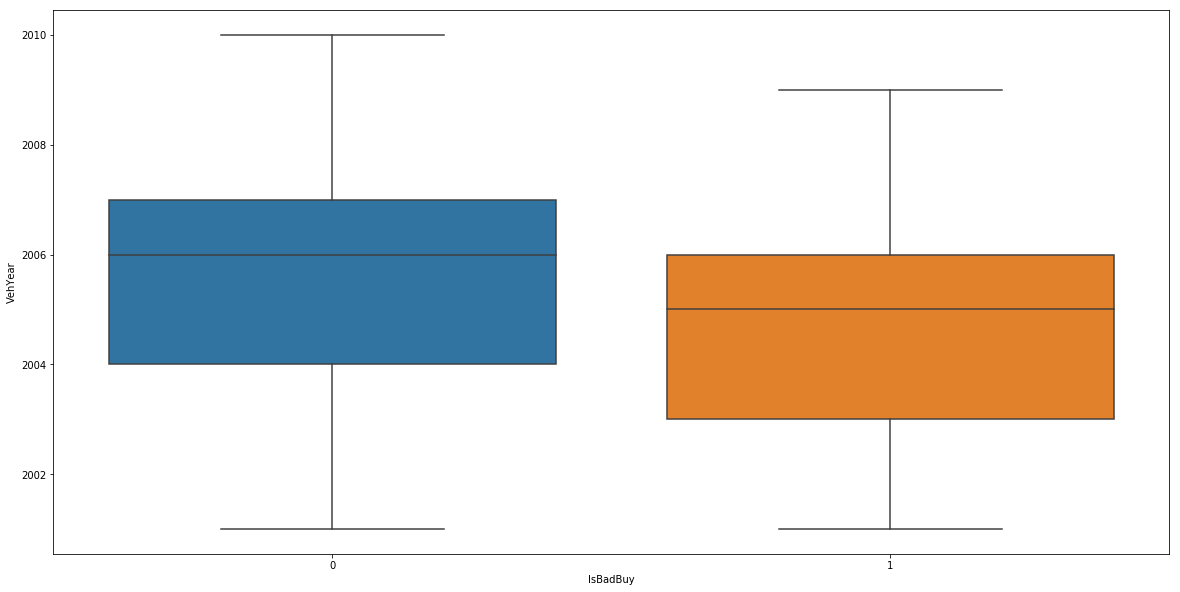

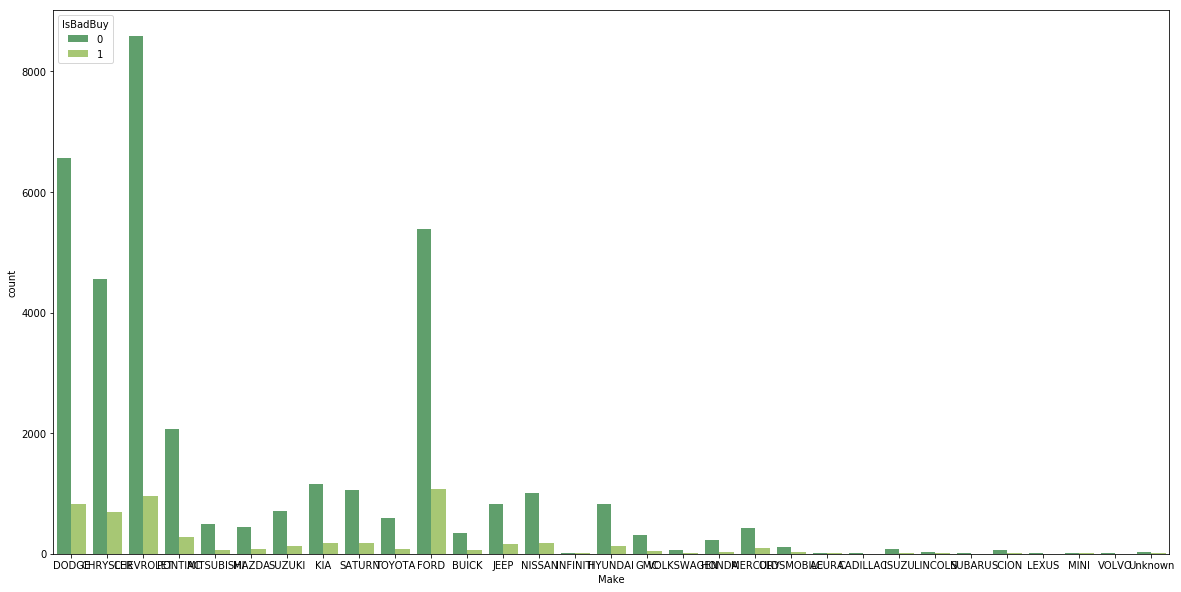

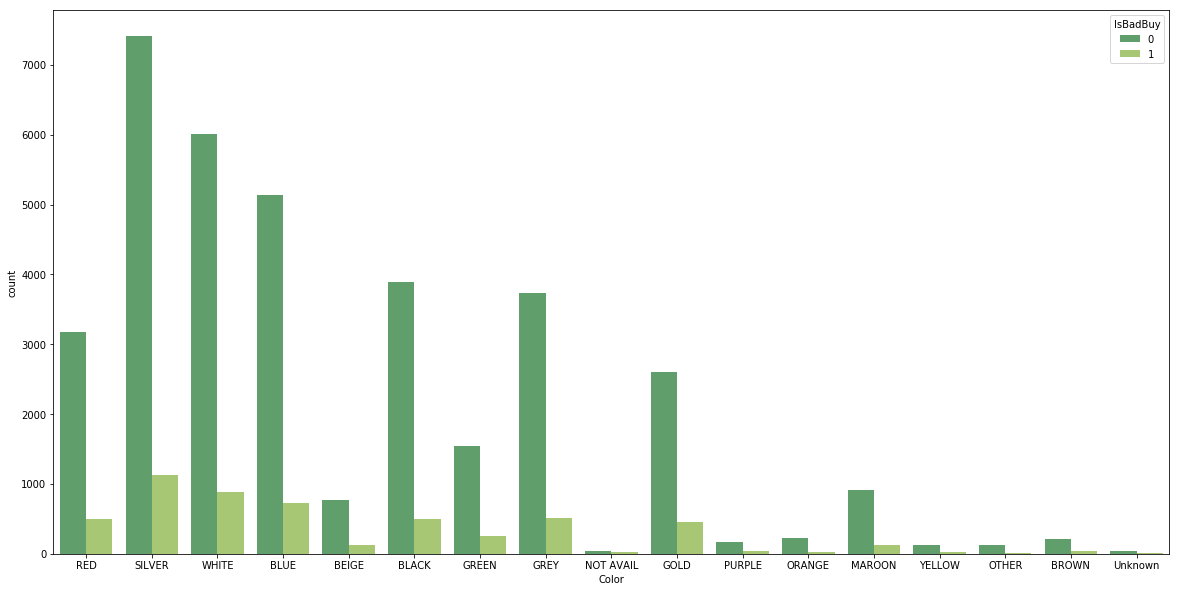

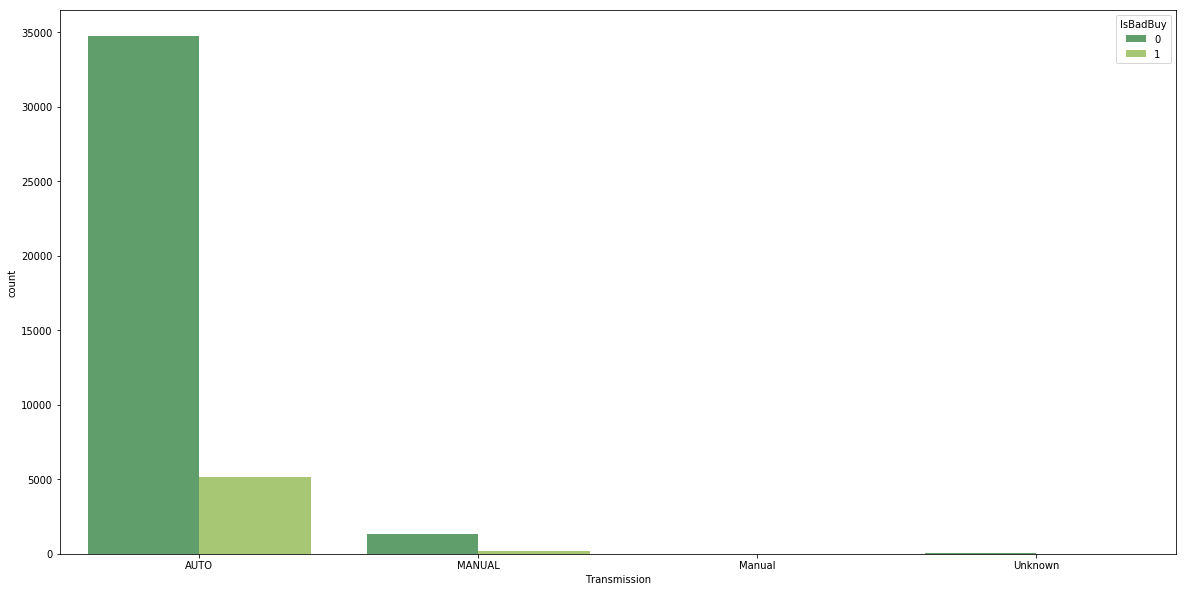

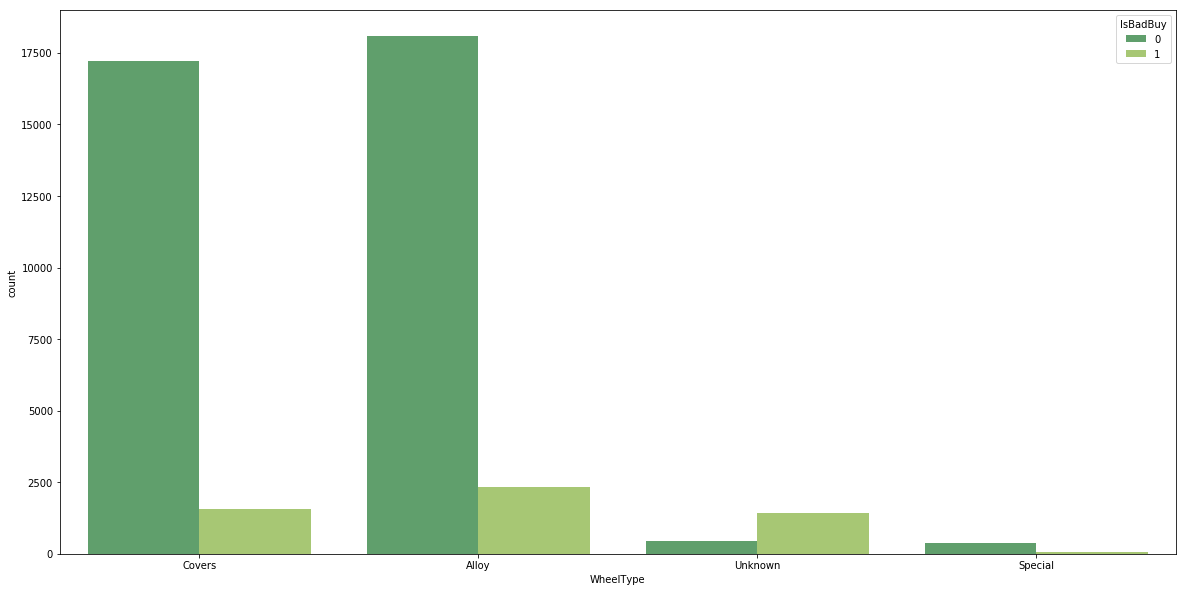

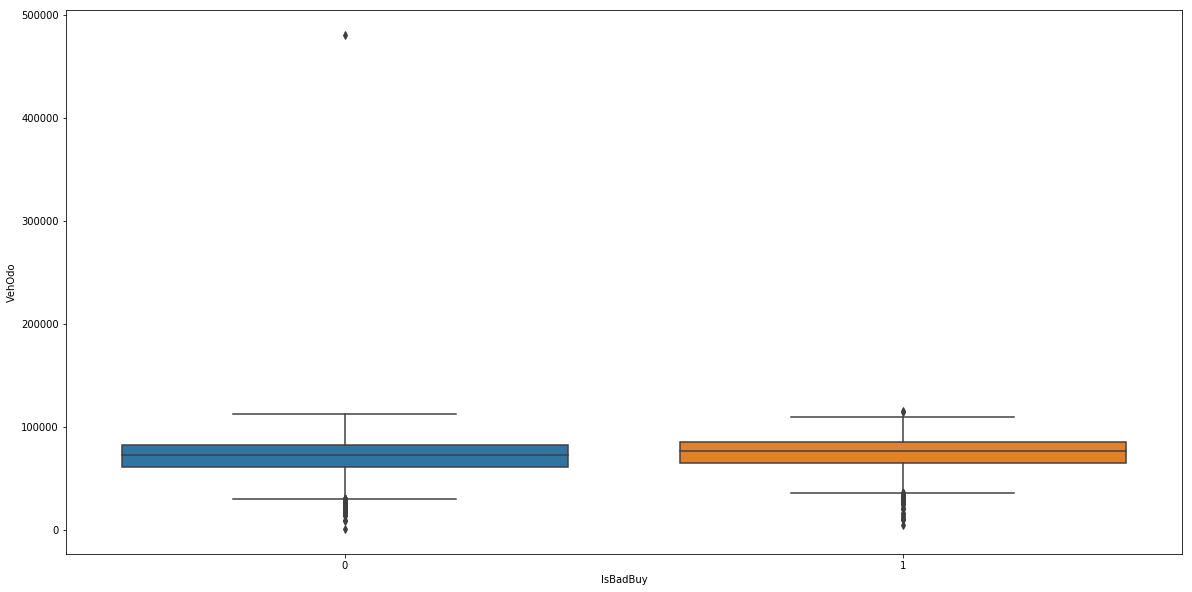

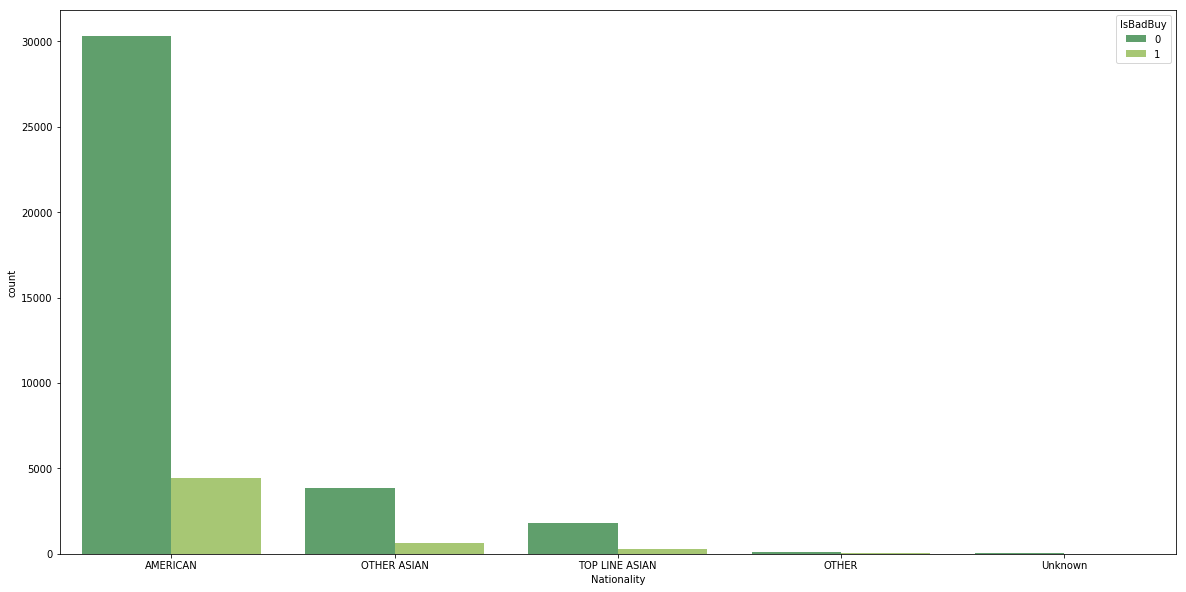

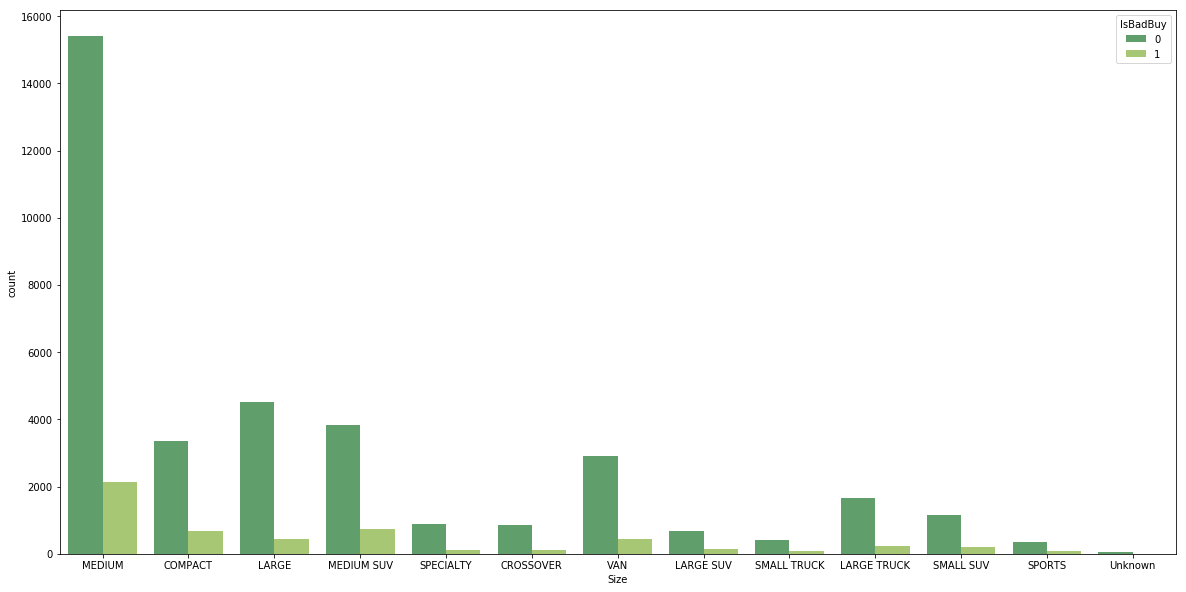

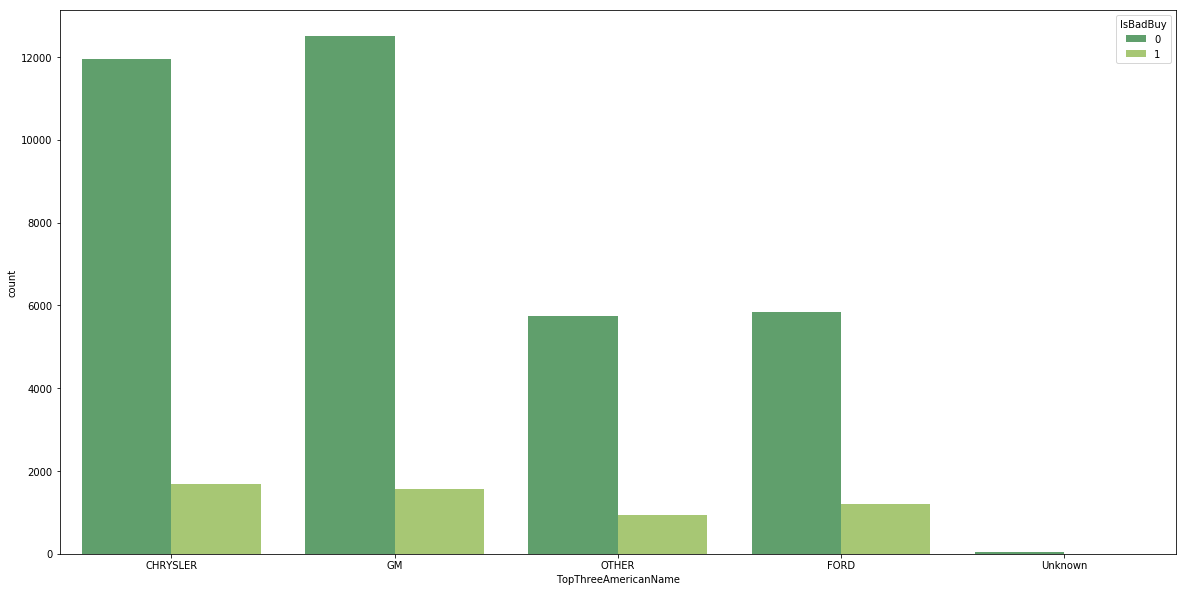

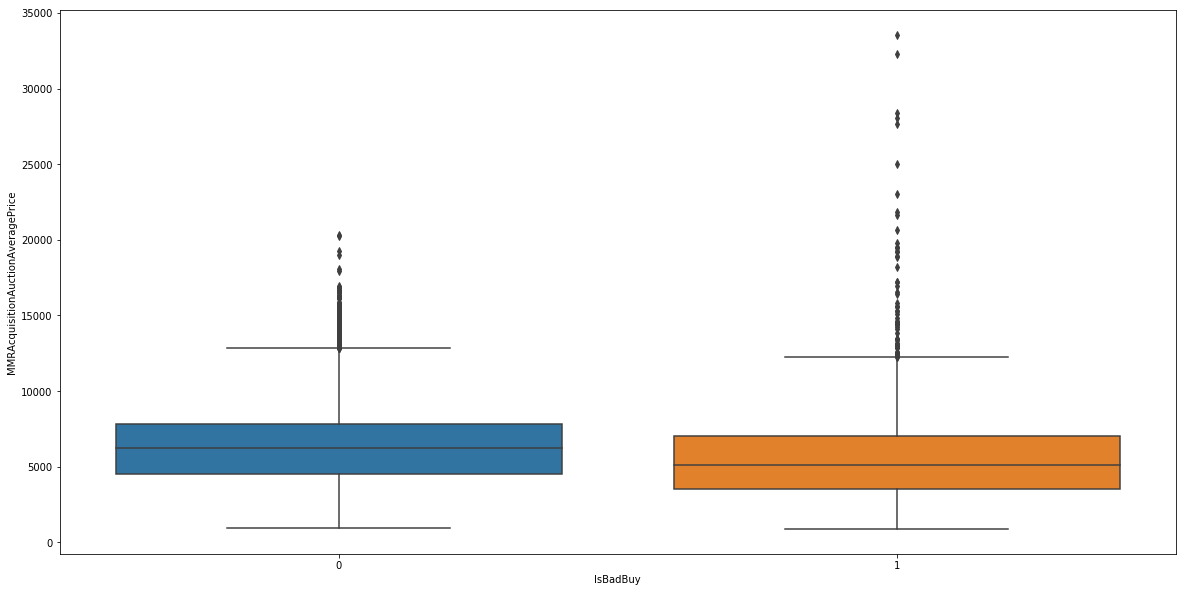

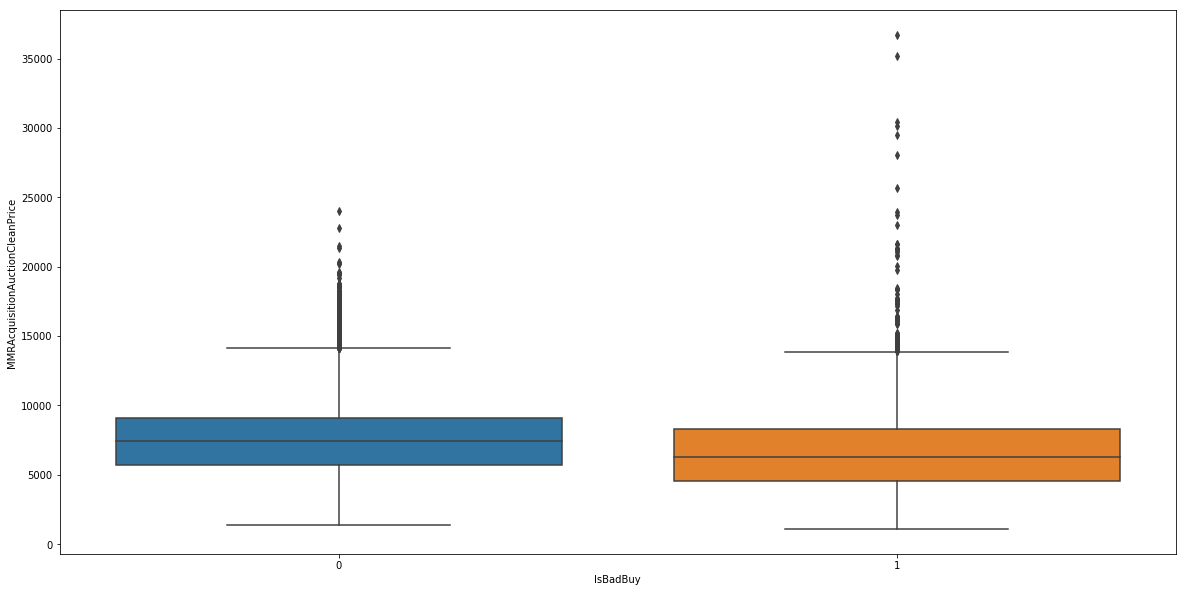

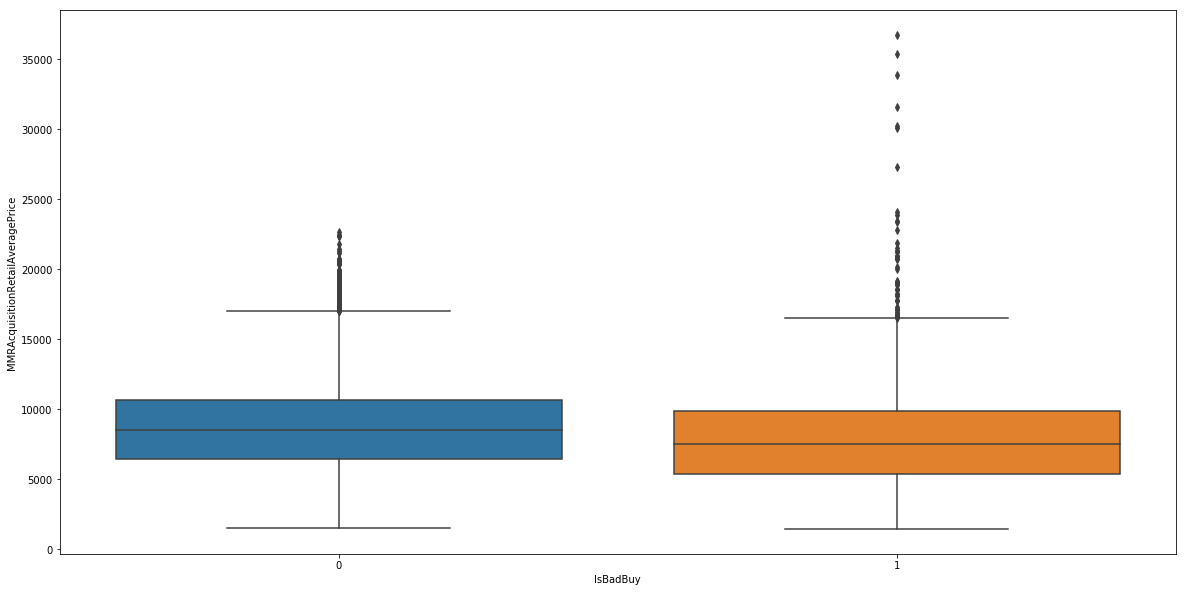

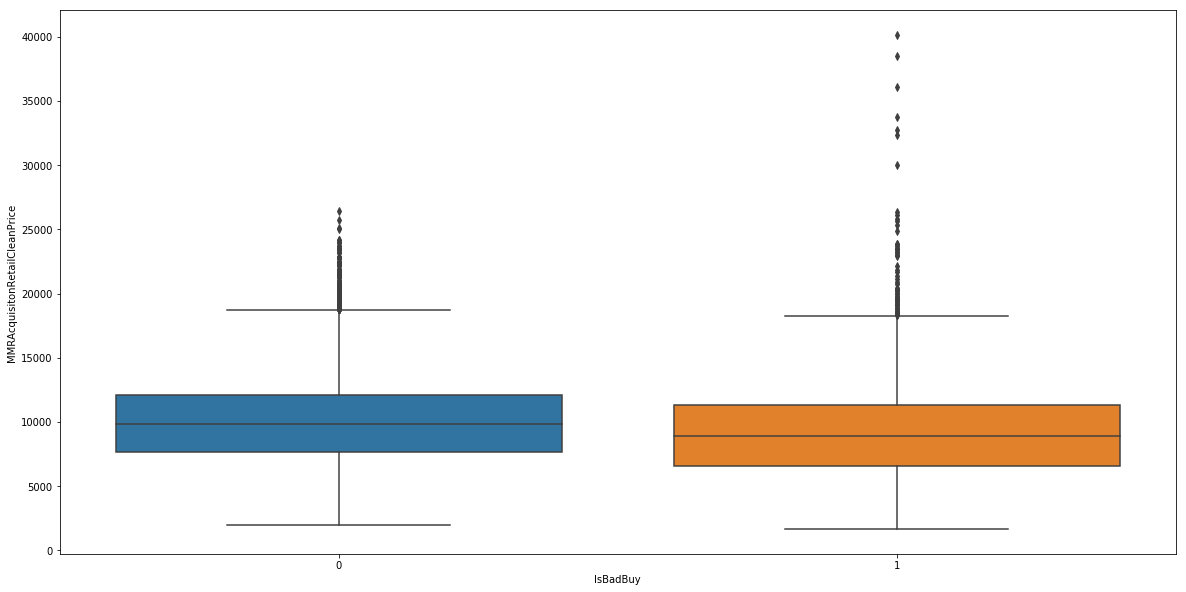

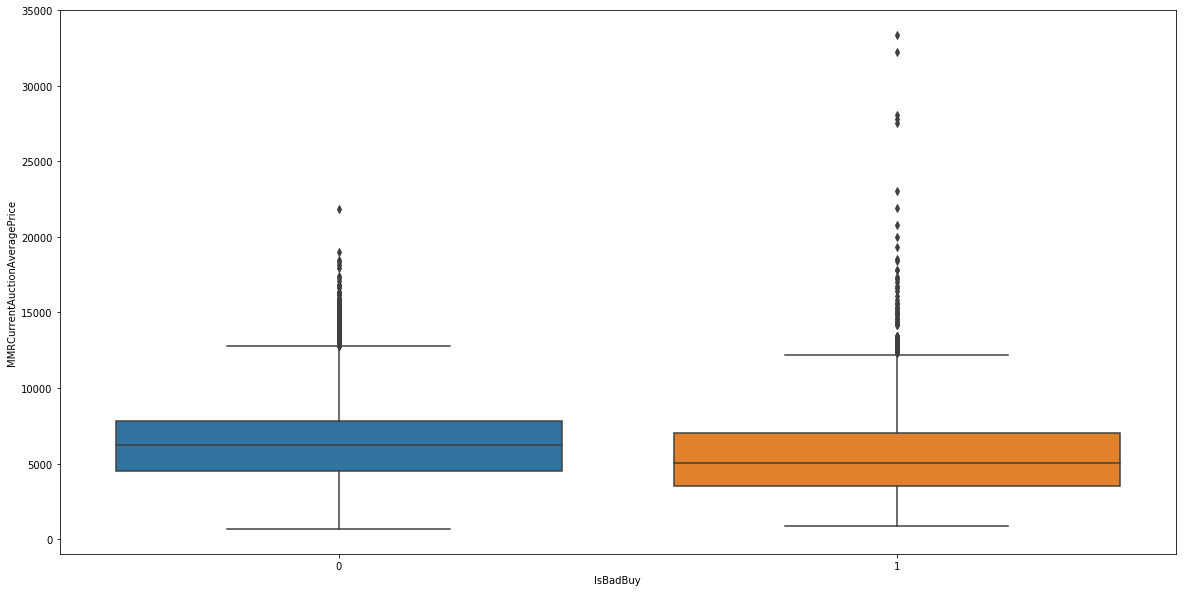

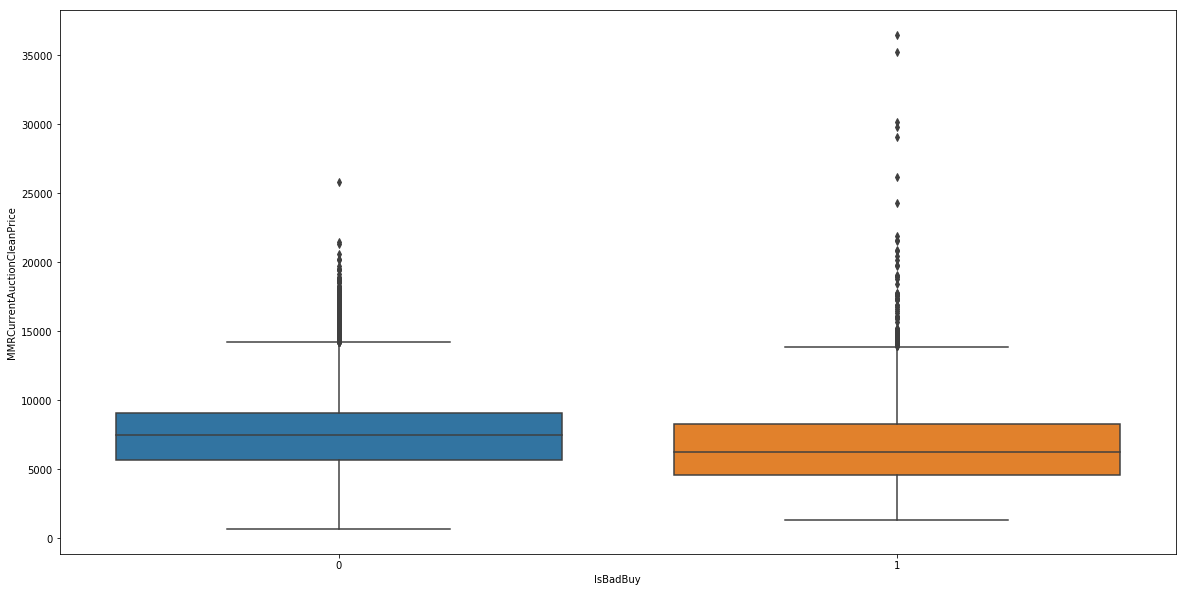

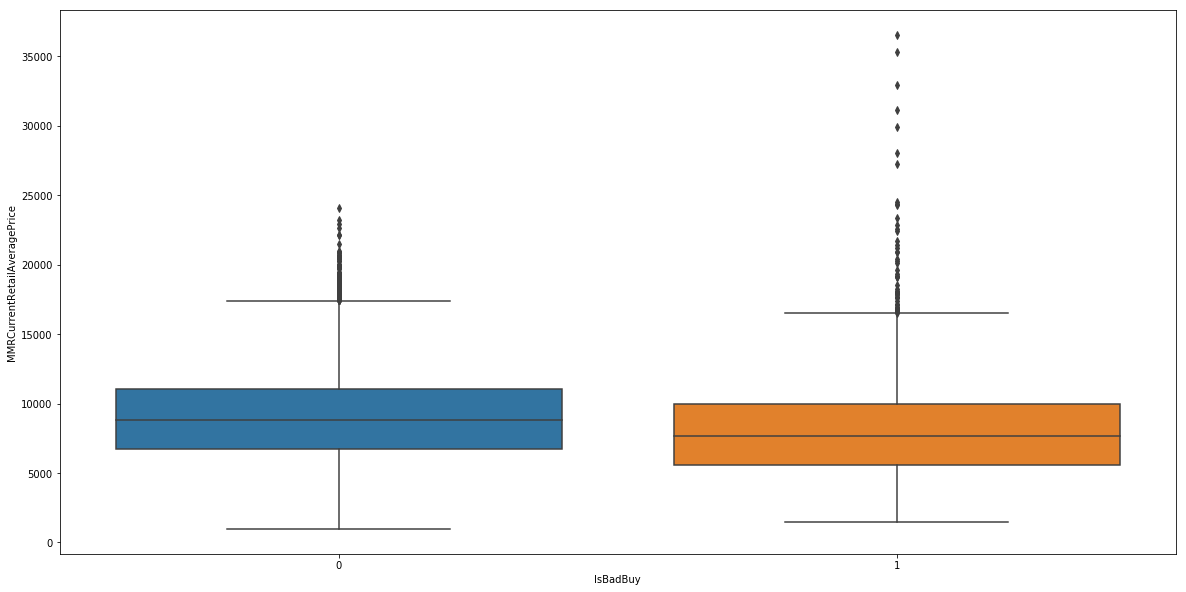

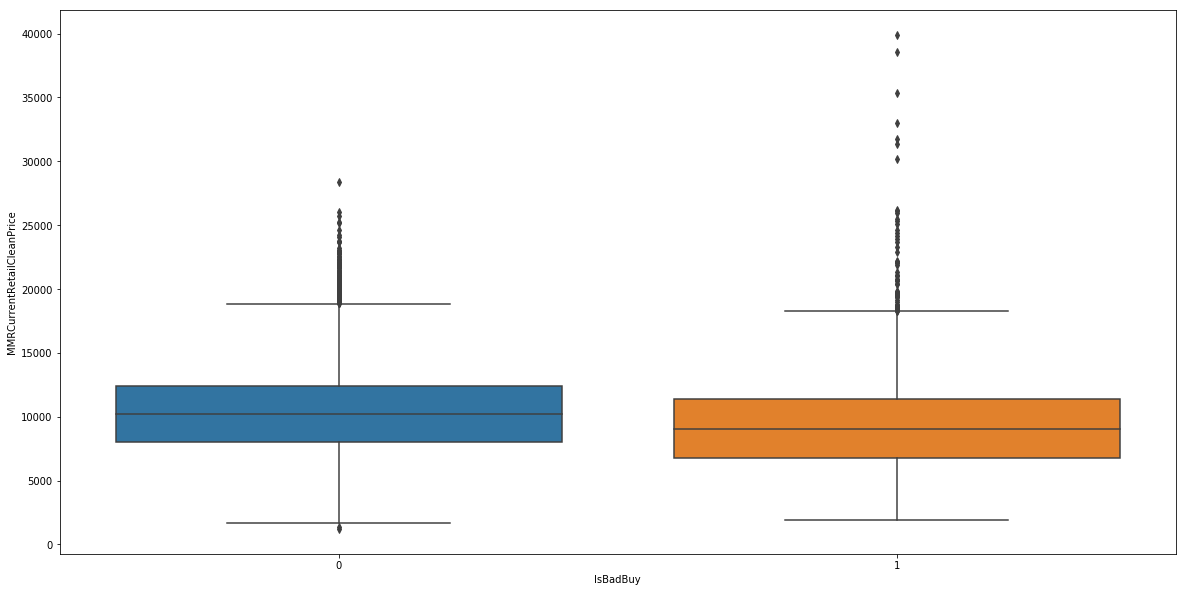

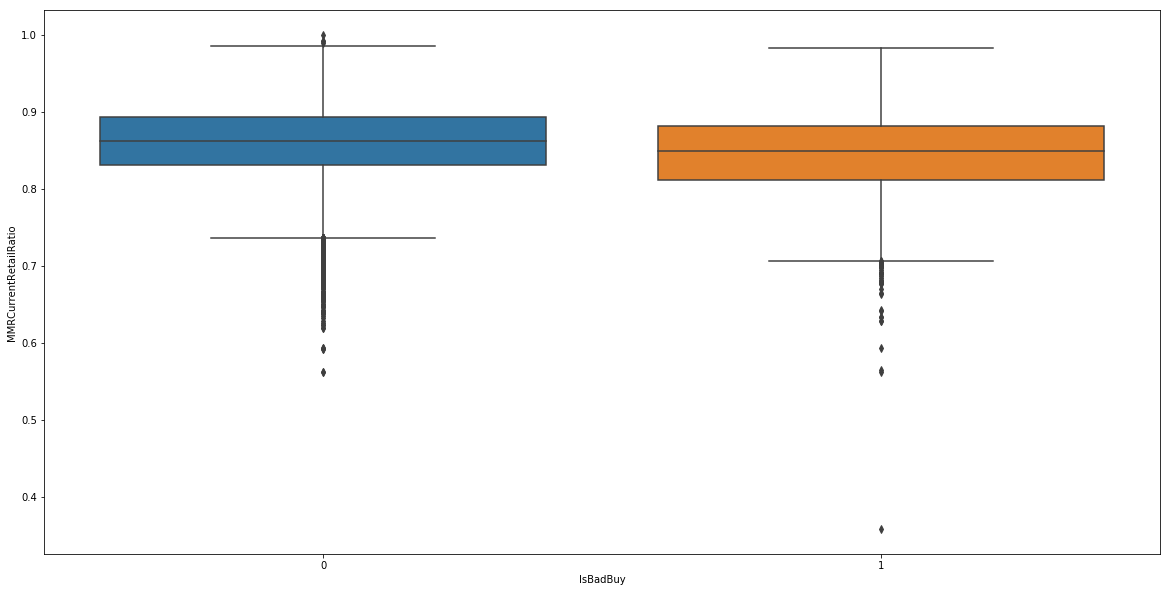

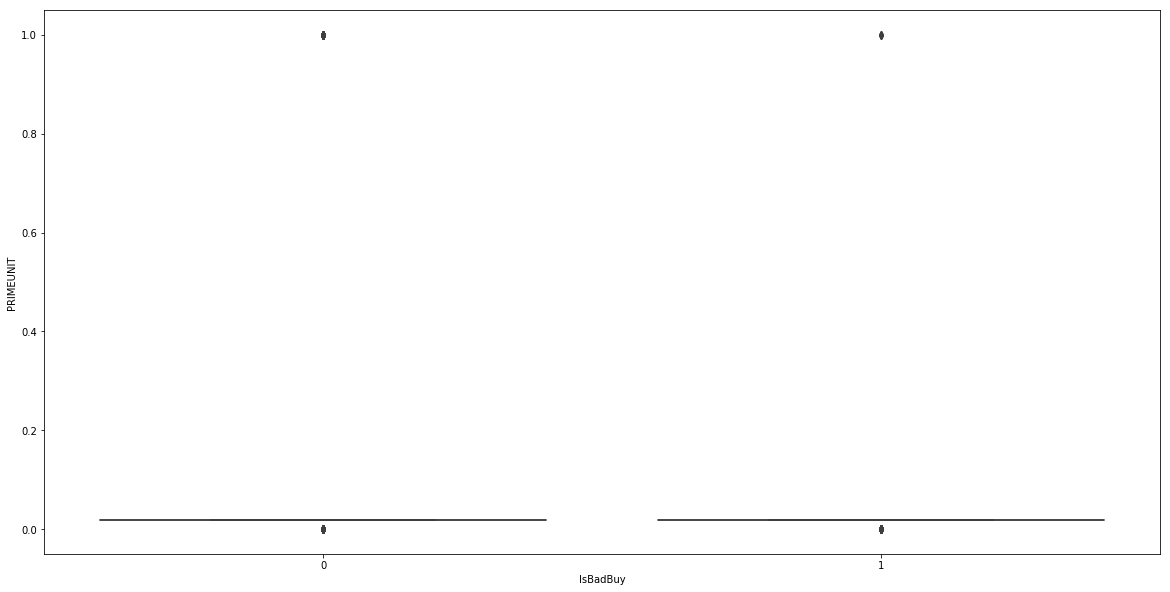

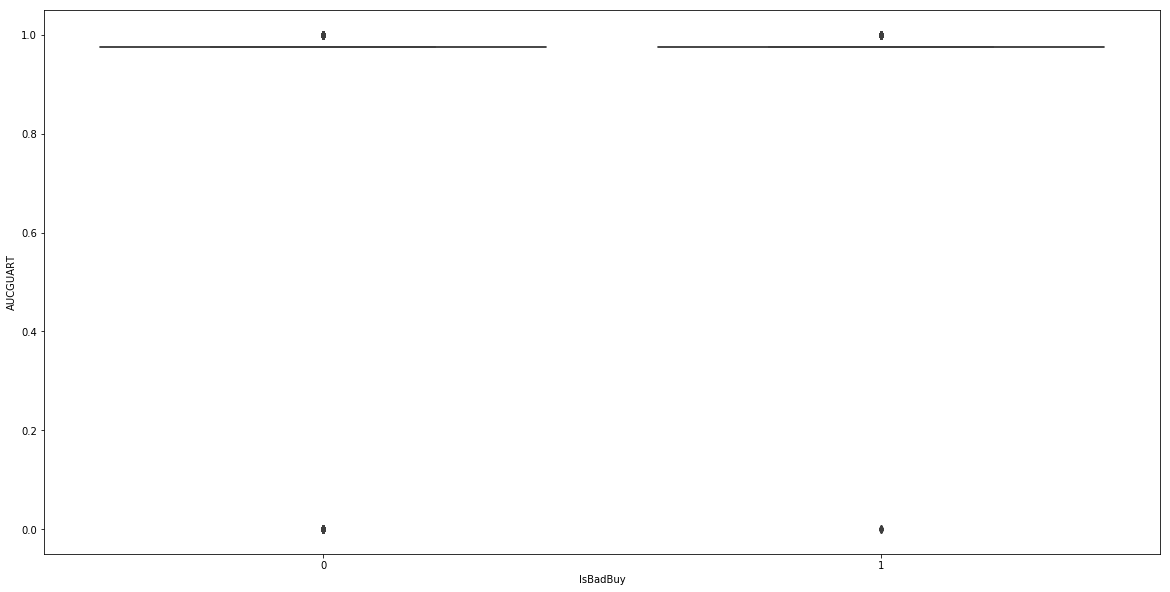

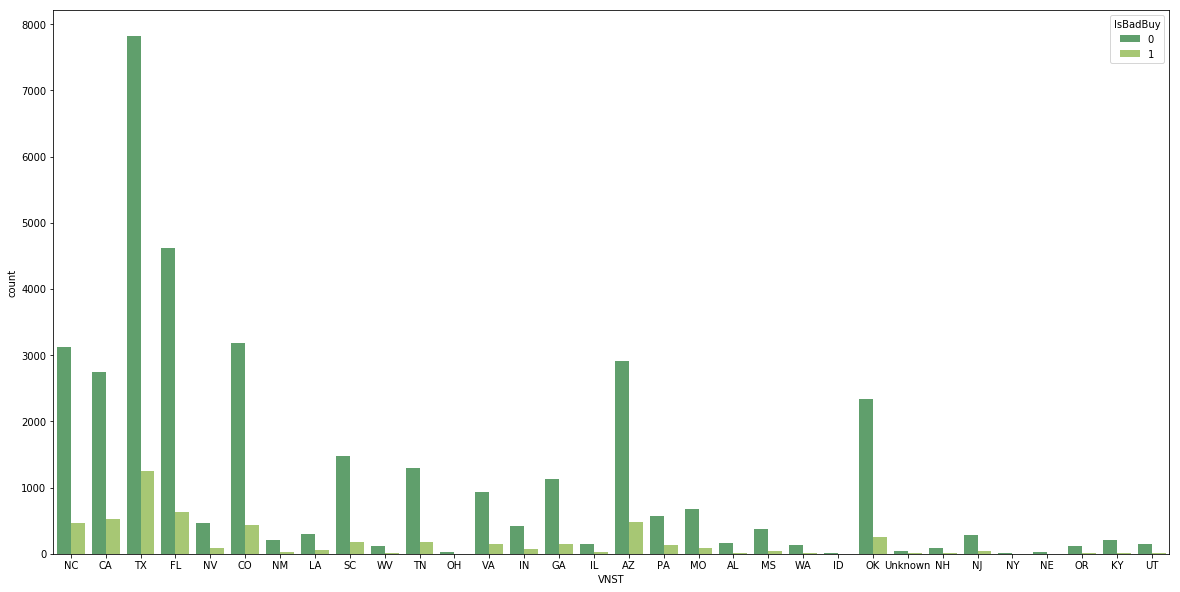

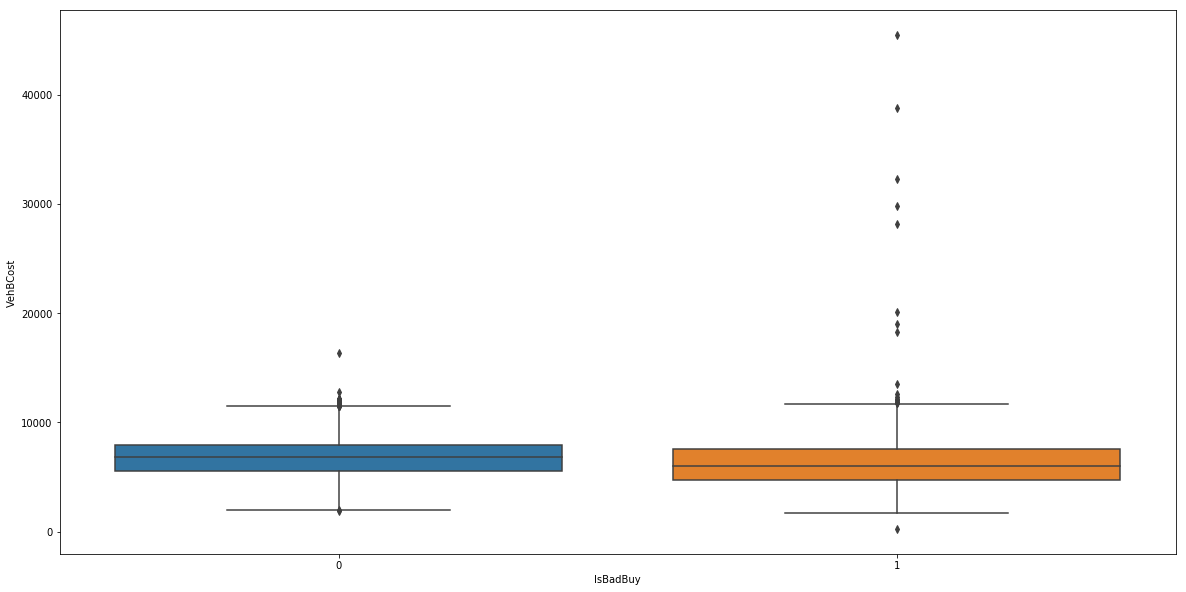

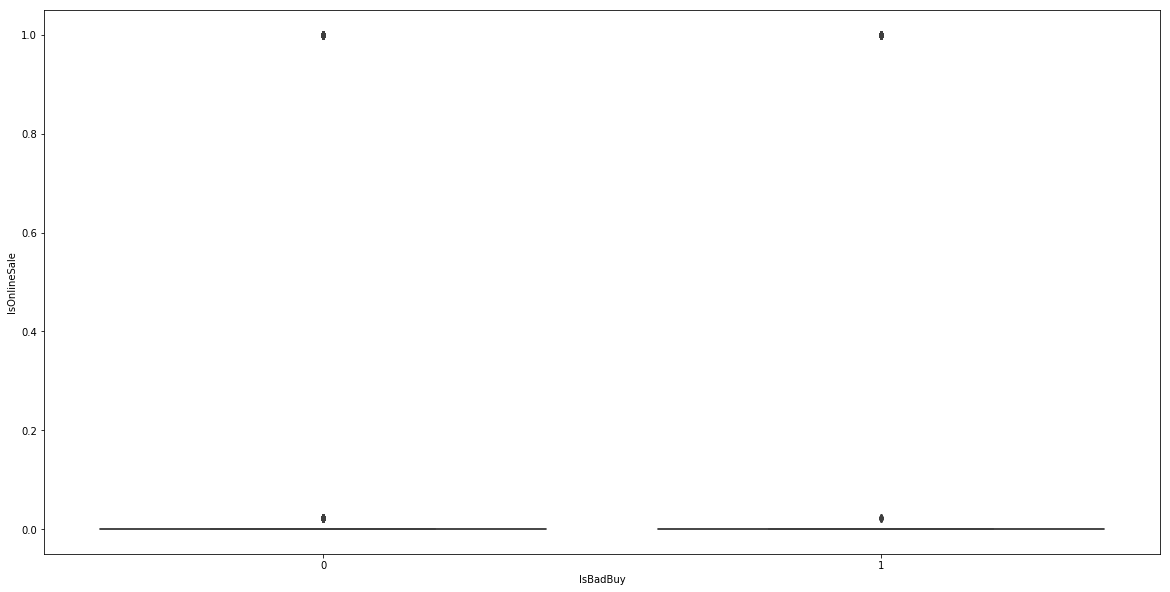

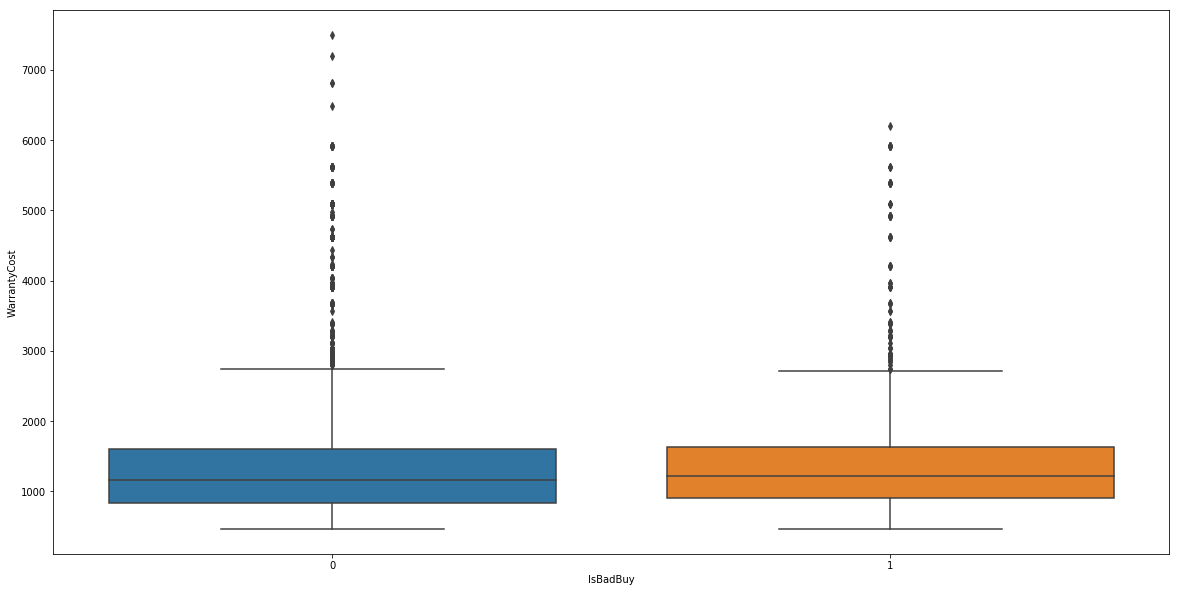

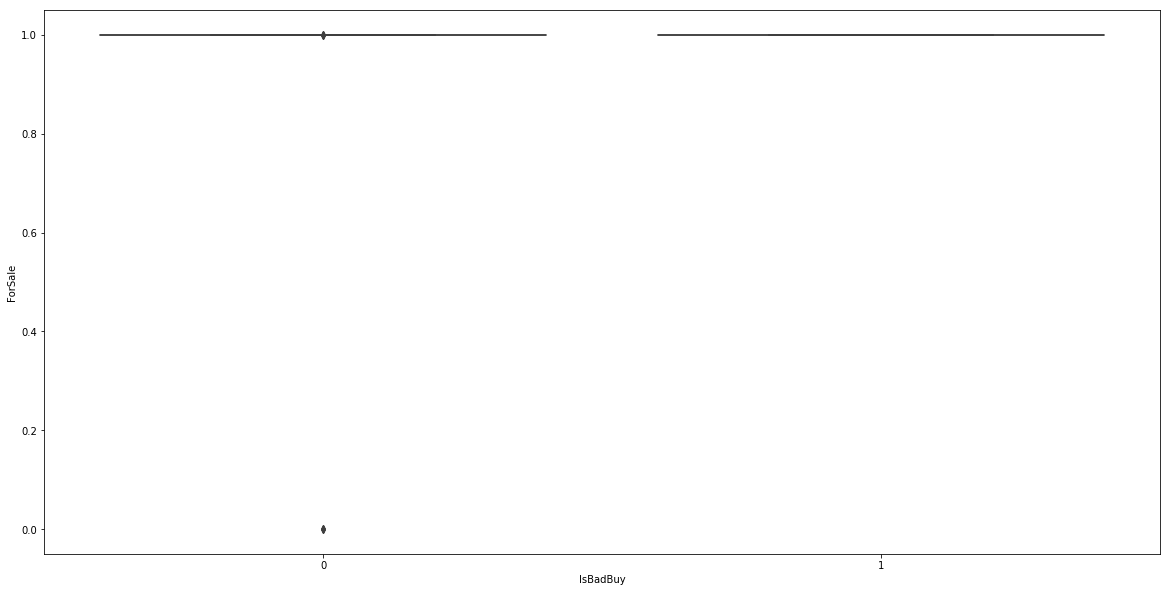

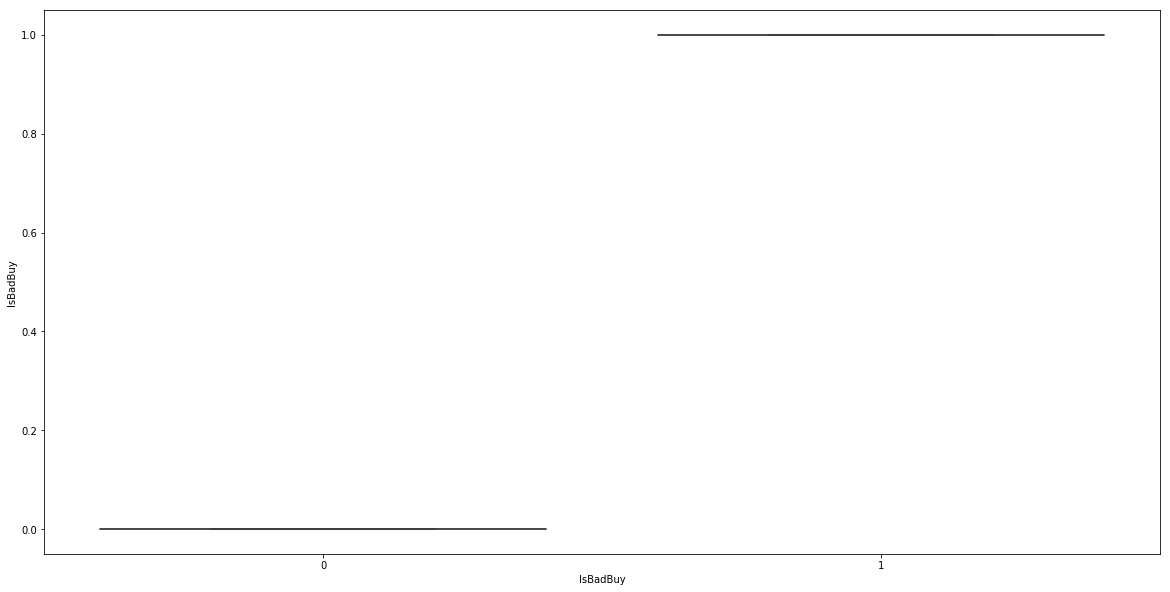

In [17]:
Categr = df.select_dtypes(include=[object])
Numer = df.select_dtypes(include=[np.number])
def plotAllCols (df):
    for colName in df.columns:
        plt.figure(figsize=(20,10))
        if colName in Categr:
            ### if it's categorial column, plot hist diagram 
            sns.countplot(x=colName, data = df, hue="IsBadBuy", palette="summer")
        elif colName in Numer:
            ### if it's Numerical column, plot box diagram
            sns.boxplot(x="IsBadBuy", y=colName, data = df )
plotAllCols(df)

We found which values are most related to IsBadBuy.

### 4. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice


In [18]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 27 columns):
Auction                              41476 non-null object
VehYear                              41476 non-null float64
Make                                 41476 non-null object
Color                                41476 non-null object
Transmission                         41476 non-null object
WheelType                            41476 non-null object
VehOdo                               41476 non-null float64
Nationality                          41476 non-null object
Size                                 41476 non-null object
TopThreeAmericanName                 41476 non-null object
MMRAcquisitionAuctionAveragePrice    41476 non-null float64
MMRAcquisitionAuctionCleanPrice      41476 non-null float64
MMRAcquisitionRetailAveragePrice     41476 non-null float64
MMRAcquisitonRetailCleanPrice        41476 non-null float64
MMRCurrentAuctionAveragePrice        41476 non-null float64

### 5. What distribution scheme did you use? What data partitioning allocation did you set? Explain your selection.

In [23]:
y = df['IsBadBuy']
X = df.drop(['IsBadBuy'], axis=1)

In [24]:
rs = 10
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

C:\Users\JDH67\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


#### distribution scheme: 
We use stratify sampling for splitting the training and the test sets, so the portion of kicks in the training and test set will be the same as the original data set. In order to deal with the imbalanced dataset, we use random oversampling to test the performance. However, we only apply ROS and on the training dataset since we want the test dataset can have the similar distribution.

#### data partitioning: 
70% of the entire dataset for training, 15% of the entire dataset for validation and 15% of the entire dataset for testing.

## TASK 2

In [29]:
def printLRTopImportant(model, top = 5):
    
    coef = model.coef_[0]
    indices = np.argsort(np.absolute(coef))
    indices = np.flip(indices, axis=0)
    indices = indices[:top]
    for i in indices:
        print(feature_names[i], ':', coef[i])

def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])

def visualize_decision_tree(dm_model, feature_names, save_name):
    dotfile = StringIO()
    export_graphviz(dm_model, out_file=dotfile, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph[0].write_png(save_name) # saved in the following file

### build a decision model using the default setting

In [25]:
# simple decision tree training
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

### a. What is the classification accuracy on training and test datasets?


In [26]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Train accuracy: 0.9998622257431199
Test accuracy: 0.822550831792976


In [27]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     10832
           1       0.34      0.38      0.36      1611

   micro avg       0.82      0.82      0.82     12443
   macro avg       0.62      0.63      0.63     12443
weighted avg       0.83      0.82      0.83     12443



### b. What is the size of tree (i.e. number of nodes)?

In [28]:
print("Number of nodes: ",model.tree_.node_count)

Number of nodes:  6307


### c. How many leaves are in the tree that is selected based on the validation dataset?¶


In [30]:
print (len(set(model.apply(X_test))))


1809


### d. Which variable is used for the first split? What are the competing splits for this first split?¶


In [64]:
dotfile = StringIO()
export_graphviz(model, out_file=dotfile, feature_names=X.columns)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph[0].write_png("dt_strcture.png")

From the graph,we know that 'WheelType_Unknown' is used for the first split,and the competing splits is WheelType_Unknown>0.5

### e. What are the 5 important variables in building the tree?

In [31]:
# grab feature importances from the model and feature name from the original X
importances = model.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:5]
print('5 important variable:')
for i in indices:
    print(feature_names[i], ':', importances[i])

5 important variable:
WheelType_Unknown : 0.1780155539472149
VehOdo : 0.06796461816587349
VehBCost : 0.0645346418415496
MMRCurrentRetailRatio : 0.05395712965124744
MMRAcquisitionAuctionCleanPrice : 0.04803856679346913


### f. Report if you see any evidence of model overfitting.

In [32]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Train accuracy: 0.9998622257431199
Test accuracy: 0.822550831792976


Test accuracy is significantly lower than train accuracy

### g.Did changing the default setting help imoroving the model?Answer the question on the best performing tree

In [33]:
test_score = []
train_score = []

# check the model performance for max depth from 2-20
for max_depth in range(2, 20):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))

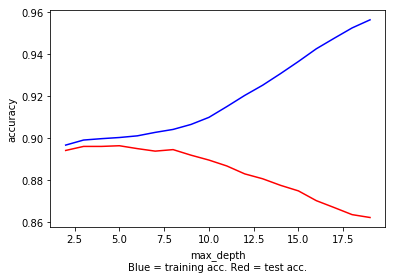

In [34]:
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(range(2, 20), train_score, 'b', range(2,20), test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.show()

From the graph below we firstly define 2-7 might be  the best max-depth,then we run it

In [50]:
#retrain with a small max_depth limit
def accuracy(max_depth):
    print('nax_depth is :',max_depth)
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs)
    model.fit(X_train, y_train)
    print("Train accuracy:", model.score(X_train, y_train))
    print("Test accuracy:", model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

In [51]:
for i in range(2,7):
    accuracy(i)

nax_depth is : 2
Train accuracy: 0.8966348637757036
Test accuracy: 0.8940769910793217
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.82      0.23      0.36      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.86      0.61      0.65     12443
weighted avg       0.89      0.89      0.87     12443

nax_depth is : 3
Train accuracy: 0.8990459132711053
Test accuracy: 0.8960057863859198
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.83      0.25      0.38      1611

   micro avg       0.90      0.90      0.90     12443
   macro avg       0.87      0.62      0.66     12443
weighted avg       0.89      0.90      0.87     12443

nax_depth is : 4
Train accuracy: 0.8997003409912858
Test accuracy: 0.8960057863859198
              precision    recall  f1-score   support

           0       0.90      0.99

We can find when max depth is 5,the accuracy is the best.So the best model is when max depth equal to 5.

In [104]:
# grab feature importance from the model and feature name from the original X
importances = model.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:15]

for i in indices:
    print(feature_names[i], ':', importances[i])

# visualize
dotfile = StringIO()
export_graphviz(model, out_file=dotfile, feature_names=X.columns)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph[0].write_png("dt_viz_withsmalldepth.png") # saved in the following file

WheelType_Unknown : 0.760593090553103
VehYear : 0.07557118263097282
Auction_MANHEIM : 0.04712194763507332
Transmission_AUTO : 0.026619989395731788
VehBCost : 0.02415953928586535
MMRAcquisitionAuctionAveragePrice : 0.012348612411067546
MMRCurrentRetailAveragePrice : 0.00903135071473762
PRIMEUNIT : 0.008359435820819168
VehOdo : 0.0071805785766857234
VNST_KY : 0.0067092022987729006
VNST_TX : 0.006211817551258122
VNST_AZ : 0.003503648118304952
WarrantyCost : 0.003295510606326451
Color_BROWN : 0.0029041471871385557
MMRCurrentAuctionCleanPrice : 0.0022574649855467417


### Build another decision tree tuned with GridSearchCV

In [53]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7),
          'min_samples_leaf': range(20, 200, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

# test the best model
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.8989081390142252
Test accuracy: 0.895764686972595
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.83      0.25      0.38      1611

   micro avg       0.90      0.90      0.90     12443
   macro avg       0.86      0.62      0.66     12443
weighted avg       0.89      0.90      0.87     12443

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 20}


### a. accuracy

In [106]:
# grid search CV #2
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 6),
          'min_samples_leaf': range(10, 60,5)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

# test the best model
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.8994936796059656
Test accuracy: 0.8960057863859198
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.84      0.24      0.38      1611

   micro avg       0.90      0.90      0.90     12443
   macro avg       0.87      0.62      0.66     12443
weighted avg       0.89      0.90      0.87     12443

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}


### b size of the tree

In [108]:
print("Number of nodes: ", cv.best_estimator_.tree_.node_count)

Number of nodes:  27


### c how many leaves

In [ ]:
print (len(set(model.apply(X_test))))

982

### 3.what is the significant difference?

In [54]:
print("Default  Model: \n")
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print("\n\n")

print("GridSearch Model: \n")
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))
y_pred = cv.predict(X_test)
print("Classification report: \n", classification_report(y_test, y_pred))





Default  Model: 

Train accuracy: 0.9002514380188061
Test accuracy: 0.8963272522703528
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.84      0.25      0.38      1611

   micro avg       0.90      0.90      0.90     12443
   macro avg       0.87      0.62      0.66     12443
weighted avg       0.89      0.90      0.87     12443




GridSearch Model: 

Train accuracy: 0.8989081390142252
Test accuracy: 0.895764686972595
Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.83      0.25      0.38      1611

   micro avg       0.90      0.90      0.90     12443
   macro avg       0.86      0.62      0.66     12443
weighted avg       0.89      0.90      0.87     12443



### 4.which car can be potential 'kicks'

These cars which wheeltyoe is unknown

## Task 3

### 3.1

We already fix all the values in task 1
* MMRAcquisitionAuctionAveragePrice
* MMRAcquisitionAuctionCleanPrice
* MMRAcquisitionRetailAveragePrice
* MMRAcquisitonRetailCleanPrice
* MMRCurrentAuctionAveragePrice
* MMRCurrentAuctionCleanPrice
* MMRCurrentRetailAveragePrice
* MMRCurrentRetailCleanPrice
* MMRCurrentRetailRatio
* VehOdo
* Make
* Color
* Auction

In [ ]:
y = df['IsBadBuy']
X = df.drop(['IsBadBuy'], axis=1)

In [ ]:
rs = 10
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

### 2.Variables which need to apply transformation methods.

#### Varibales which are normal distribution,so we choose  
* VehOdo
* MMRAcquisitionAuctionAveragePrice  
* MMRAcquisitionAuctionCleanPrice  
* MMRAcquisitionRetailAveragePrice  
* MMRAcquisitionRetailCleanPrice  
* MMRCurrentAuctionAveragePrice  
* MMRCurrentAuctionCleanPrice  
* MMRCurrentRetailAveragePrice  
* MMRCurrentRetailCleanPrice   
* VehBCost  
* Warranty cost 



In [57]:
col_names = ['VehOdo','MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
                        'MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio','VehBCost','WarrantyCost']

In [58]:
scaled_features = df.copy()
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features

In [59]:
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [60]:
scaled_features[col_names] = features

In [61]:
y = scaled_features['IsBadBuy']
X = scaled_features.drop(['IsBadBuy'], axis=1)

## 3.3

### H:Name the regression function

logistic regression

In [62]:
rs = 10
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

C:\Users\JDH67\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [63]:
model = LogisticRegression(random_state=rs)

# fit it to training data
model.fit(X_train, y_train)

C:\Users\JDH67\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### i:How much was the difference in performance of two models build,default and optimal

In [64]:
# training and test accuracy
print("default setting")
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# classification report on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

default setting
Train accuracy: 0.8968759687252437
Test accuracy: 0.8929518604838061
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.76      0.25      0.38      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.83      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443



In [66]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

# test the best model
print("grid search cv")
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

C:\Users\JDH67\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


grid search cv
Train accuracy: 0.8968759687252437
Test accuracy: 0.8929518604838061
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.76      0.25      0.38      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.83      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443

{'C': 1}


In [129]:
feature_names = X.columns
coef = model.coef_[0]

# limit to 20 features, you can comment the following line to print out everything
coef = coef[:20]

for i in range(len(coef)):
    print(feature_names[i], ':', coef[i])

VehYear : -0.0007505083546732695
VehOdo : 0.11012990880895071
MMRAcquisitionAuctionAveragePrice : -0.4083608156480042
MMRAcquisitionAuctionCleanPrice : -0.277523057134777
MMRAcquisitionRetailAveragePrice : 0.42267138862474574
MMRAcquisitonRetailCleanPrice : 0.3111700767116875
MMRCurrentAuctionAveragePrice : 0.15711105908445563
MMRCurrentAuctionCleanPrice : 0.07943485577091024
MMRCurrentRetailAveragePrice : -0.1304658885200984
MMRCurrentRetailCleanPrice : -0.301401318932105
MMRCurrentRetailRatio : -0.0804924876781284
PRIMEUNIT : 0.03717162405301817
AUCGUART : 0.021442540691143413
VehBCost : -0.2542098195478223
IsOnlineSale : -0.17629060977679742
WarrantyCost : 0.15660004555092957
ForSale : 0.007749074196103428
Auction_ADESA : 0.048432323928671285
Auction_MANHEIM : 0.07981684677712432
Auction_OTHER : 0.07427984610849227


In [130]:
# grab feature importances from the model and feature name from the original X
coef = model.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

WheelType_Unknown : 2.5648072611347024
WheelType_Covers : -1.137991834431275
WheelType_Alloy : -0.9892953915222739
Size_LARGE SUV : 0.5135436255075869
VNST_PA : 0.4599494100153839
WheelType_Special : -0.4314776873047414
MMRAcquisitionRetailAveragePrice : 0.42267138862474574
MMRAcquisitionAuctionAveragePrice : -0.4083608156480042
Size_VAN : -0.39491782440061196
VNST_TN : -0.3795911085753162
Size_LARGE : -0.3723023134514203
Size_MEDIUM SUV : 0.3479155948551662
VNST_GA : -0.32274114246106456
MMRAcquisitonRetailCleanPrice : 0.3111700767116875
MMRCurrentRetailCleanPrice : -0.301401318932105
MMRAcquisitionAuctionCleanPrice : -0.277523057134777
VNST_CA : 0.27477951176442544
Transmission_AUTO : 0.26889081362904926
Size_MEDIUM : -0.26620030510096016
Make_CHEVROLET : -0.2571305271959222


### K. Which varibales are included in the regression model

In [173]:
print(list(feature_names))

['VehYear', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'PRIMEUNIT', 'AUCGUART', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'ForSale', 'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER', 'Auction_Unknown', 'Make_ACURA', 'Make_BUICK', 'Make_CADILLAC', 'Make_CHEVROLET', 'Make_CHRYSLER', 'Make_DODGE', 'Make_FORD', 'Make_GMC', 'Make_HONDA', 'Make_HYUNDAI', 'Make_INFINITI', 'Make_ISUZU', 'Make_JEEP', 'Make_KIA', 'Make_LEXUS', 'Make_LINCOLN', 'Make_MAZDA', 'Make_MERCURY', 'Make_MINI', 'Make_MITSUBISHI', 'Make_NISSAN', 'Make_OLDSMOBILE', 'Make_PONTIAC', 'Make_SATURN', 'Make_SCION', 'Make_SUBARU', 'Make_SUZUKI', 'Make_TOYOTA', 'Make_Unknown', 'Make_VOLKSWAGEN', 'Make_VOLVO', 'Color_BEIGE', 'Color_BLACK', 'Color_BLUE', 'Color_BROWN', 'Colo

### i .the top 5 important variables(in the order) in the model

WheelType_Unknown  
WheelType_Covers  
WheelType_Alloy  
Size_LARGE SUV  
VNST_PA  

In [131]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

# test the best model
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

C:\Users\JDH67\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train accuracy: 0.8968759687252437
Test accuracy: 0.8929518604838061
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.76      0.25      0.38      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.83      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443

{'C': 1}


### j .show the set parameters for the best model

In [132]:
print("The best model parameters: ", cv.best_params_)

The best model parameters:  {'C': 1}


### m . what is classfication accuracy

Train accuracy: 0.8968759687252437  
Test accuracy: 0.8929518604838061

### n REPORT any sign of overfitting

There is slightly overfitting becasue test accuracy is lower than train accuracy

# Task 3.4

In [ ]:
col_names = ['VehOdo','MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
                        'MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio','VehBCost','WarrantyCost']

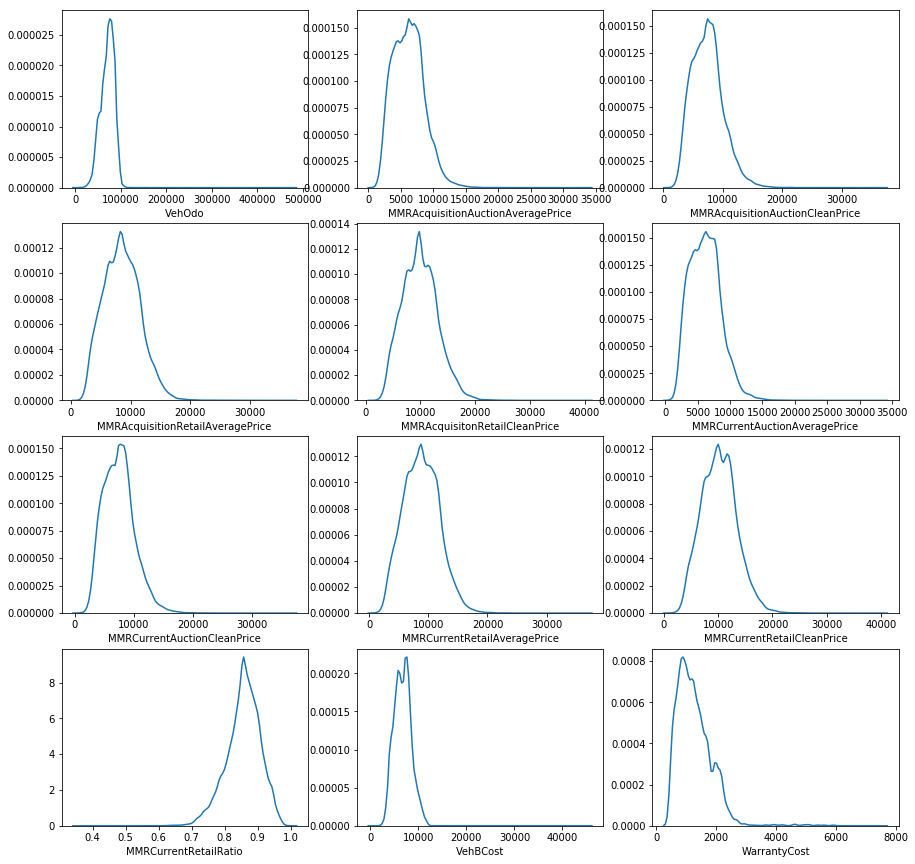

In [140]:
def plot_skewed_columns(df):
    # setting up subplots for easier visualisation
    f, axes = plt.subplots(4,3, figsize=(15,15), sharex=False)

    
    sns.distplot(df['VehOdo'].dropna(), hist=False, ax=axes[0,0])
    sns.distplot(df['MMRAcquisitionAuctionAveragePrice'].dropna(), hist=False, ax=axes[0,1])
    sns.distplot(df['MMRAcquisitionAuctionCleanPrice'].dropna(), hist=False, ax=axes[0,2])
    sns.distplot(df['MMRAcquisitionRetailAveragePrice'].dropna(), hist=False, ax=axes[1,0])

    
    sns.distplot(df['MMRAcquisitonRetailCleanPrice'].dropna(), hist=False, ax=axes[1,1])
    sns.distplot(df['MMRCurrentAuctionAveragePrice'].dropna(), hist=False, ax=axes[1,2])
    sns.distplot(df['MMRCurrentAuctionCleanPrice'].dropna(), hist=False, ax=axes[2,0])
    sns.distplot(df['MMRCurrentRetailAveragePrice'].dropna(), hist=False, ax=axes[2,1])
    sns.distplot(df['MMRCurrentRetailCleanPrice'].dropna(), hist=False, ax=axes[2,2])
    sns.distplot(df['MMRCurrentRetailRatio'].dropna(), hist=False, ax=axes[3,0])
    sns.distplot(df['VehBCost'].dropna(), hist=False, ax=axes[3,1])
    sns.distplot(df['WarrantyCost'].dropna(), hist=False, ax=axes[3,2])

    plt.show()
    
plot_skewed_columns(df)


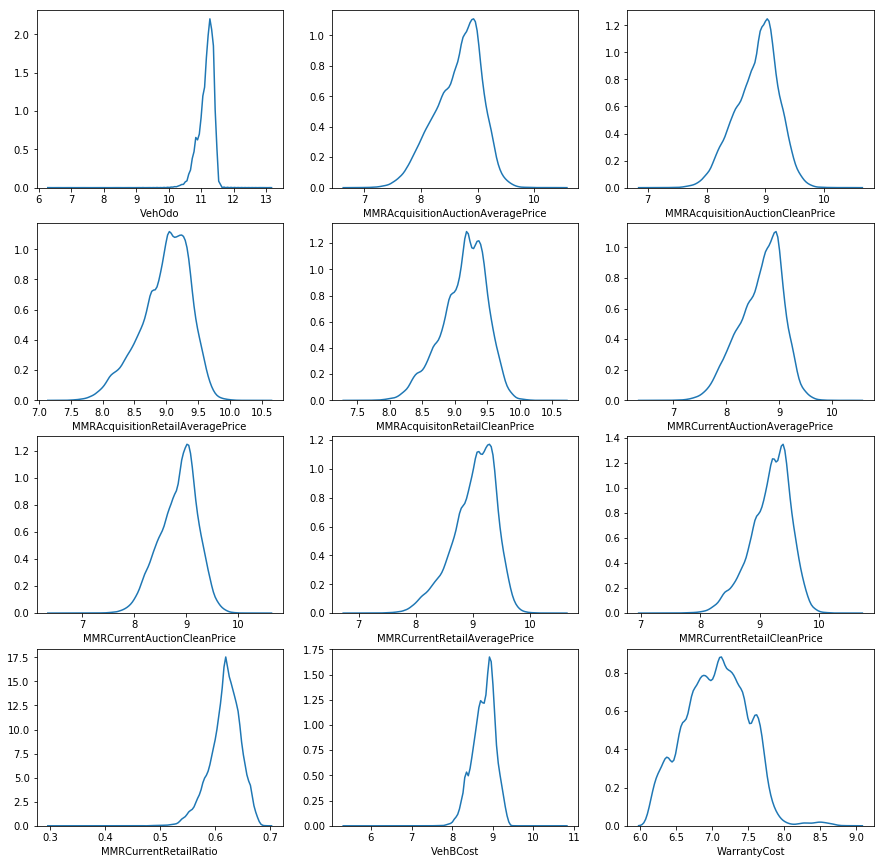

In [142]:
# copy the dataframe
columns_to_transform=col_names
df_log = df.copy()

# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)

# plot them again to show the distribution
plot_skewed_columns(df_log)

In [144]:
# create X, y and train test data partitions
y_log = df_log['IsBadBuy']
X_log = df_log.drop(['IsBadBuy'], axis=1)
X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log, test_size=0.3, stratify=y_log, 
                                                                    random_state=rs)

# standardise them again
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

C:\Users\JDH67\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


### E what is classfication accuracy on training and test datasets?

In [145]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

C:\Users\JDH67\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train accuracy: 0.8973581786243241
Test accuracy: 0.8932733263682392
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.77      0.25      0.38      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.83      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443

{'C': 0.01}


### d REPORT any sign of overfitting

There is slightly overfitting becasue test accuracy is lower than train accuracy

### rfecv

In [149]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs,solver = 'liblinear'), cv=10)
rfe.fit(X_train_log, y_train_log) # run the RFECV



X_train_sel = rfe.transform(X_train_log)
X_test_sel = rfe.transform(X_test_log)

params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_sel, y_train_log))
print("Test accuracy:", cv.score(X_test_sel, y_test_log))

y_pred = cv.predict(X_test_sel)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

C:\Users\JDH67\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train accuracy: 0.8973926221885441
Test accuracy: 0.8935144257815639
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.77      0.25      0.38      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.83      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443

{'C': 0.1}


In [173]:
print("Original feature set", X_train.shape[1])

print("Number of selectFromModel features: ",  X_train_sel_model.shape[1])

Original feature set 132
Number of selectFromModel features:  6


## SELECT BY MODEL METHOD

In [178]:

# similar parameters with the last practical
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7),
          'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train_log, y_train_log)

print(cv.best_params_)

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 20}


In [ ]:
analyse_feature_importance(cv.best_estimator_, X_log.columns)

In [157]:
from sklearn.feature_selection import SelectFromModel

# use the trained best decision tree from GridSearchCV to select features
# supply the prefit=True parameter to stop SelectFromModel to re-train the model
selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train_log)
X_test_sel_model = selectmodel.transform(X_test_log)

print(X_train_sel_model.shape)

(29033, 6)


In [165]:
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_model, y_train_log)

print("Train accuracy:", cv.score(X_train_sel_model, y_train_log))
print("Test accuracy:", cv.score(X_test_sel_model, y_test_log))

# test the best model
y_pred = cv.predict(X_test_sel_model)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.8957737746702029
Test accuracy: 0.8919070963593989
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.74      0.26      0.38      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.82      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443

{'C': 0.1}


C:\Users\JDH67\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# TASK 4

In [165]:
col_names = ['VehOdo','MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
                        'MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio','VehBCost','WarrantyCost']

In [121]:
scaled_features = df.copy()
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features


In [122]:
y = scaled_features['IsBadBuy']
X = scaled_features.drop(['IsBadBuy'], axis=1)

In [123]:
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

C:\Users\JDH67\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [124]:
model = MLPClassifier(random_state=rs)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(model)

Train accuracy: 0.8952915647711225
Test accuracy: 0.8915856304749659
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.72      0.26      0.39      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.81      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


### A What is the network architecture

In [141]:
len(model.coefs_[0])

132

In [154]:
def NetworkArchitecture(model):
    
    print("Number of Layers: ",model.n_layers_ )
    i=1
    while i<=len(model.coefs_):
        print(i,"hidden size layer is ",len(model.coefs_[i-1]))
        i=i+1
    print(i,"hidden size layer is ",1)
NetworkArchitecture(model)

Number of Layers:  3
1 hidden size layer is  132
2 hidden size layer is  100
3 hidden size layer is  1


### B how many iterations

In [85]:
print("Number of iterations it ran: ", model.n_iter_)


Number of iterations it ran:  25


### C: Any sign of over-fitting

In [90]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Train accuracy: 0.8952915647711225
Test accuracy: 0.8915856304749659


There is slightly overfiiting because test accuracy is less than train accuracy.

### D: Did the training process converge and resulted in the best model?

No

### E: What is classification accuracy on training and test datasets

In [91]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Train accuracy: 0.8952915647711225
Test accuracy: 0.8915856304749659
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.72      0.26      0.39      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.81      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443



## Task 4.2

### grid search cv

In [151]:
#size of input features
print(X_train.shape)

(29033, 132)


In [159]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred_cv = cv.predict(X_test)
print(classification_report(y_test, y_pred_cv))

print(cv.best_params_)

Train accuracy: 0.8970826301105639
Test accuracy: 0.8931125934260227
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.77      0.25      0.38      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.83      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443

{'hidden_layer_sizes': (3,)}


### a. What is the network architecture?

In [155]:
CvModel=cv.best_estimator_
NetworkArchitecture(CvModel)

Number of Layers:  3
1 hidden size layer is  132
2 hidden size layer is  3
3 hidden size layer is  1


### b. How many iterations are needed to train this network?  

In [156]:
print("Number of iterations it ran: ", CvModel.n_iter_)


Number of iterations it ran:  45


### c. Sign of overfitting?

In [157]:
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

Train accuracy: 0.8970826301105639
Test accuracy: 0.8930322269549144


There is slightly overfiiting because test accuracy is less than train accuracy.

### d. Did the training process converge and resulted in the best model? 

In [ ]:
No

### e. What is classification accuracy on training and test datasets? Is there any improvement in the outcome?

In [161]:
print('//////////////Before:')
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print('//////////////After:')
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))
print(classification_report(y_test, y_pred_cv))

//////////////Before:
Train accuracy: 0.8952915647711225
Test accuracy: 0.8915856304749659
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.72      0.26      0.39      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.81      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443

//////////////After:
Train accuracy: 0.8970826301105639
Test accuracy: 0.8931125934260227
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.77      0.25      0.38      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.83      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443



we can see that it improved both at the train accuracy ad test accuracy.

## 4.3 Would feature selection help here


#### Data transformation

In [167]:
columns_to_transform=col_names
df_log = df.copy()

# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)

In [168]:
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)
y_log = df_log['IsBadBuy']
X_log = df_log.drop(['IsBadBuy'], axis=1)
X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log, test_size=0.3, stratify=y_log, 
                                                                    random_state=rs)

# standardise them again
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

C:\Users\JDH67\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [169]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe = RFECV(estimator = LogisticRegression(random_state=rs,solver = 'liblinear'), cv=10)
rfe.fit(X_train_log, y_train_log)

print(rfe.n_features_)

48


In [170]:
# transform log 
X_train_rfe = rfe.transform(X_train_log)
X_test_rfe = rfe.transform(X_test_log)

# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_rfe, y_train_log)

print("Train accuracy:", cv.score(X_train_rfe, y_train_log))
print("Test accuracy:", cv.score(X_test_rfe, y_test_log))

y_pred = cv.predict(X_test_rfe)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)


Train accuracy: 0.8980470499087245
Test accuracy: 0.8937555251948887
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.78      0.25      0.38      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.84      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443

{'alpha': 0.01, 'hidden_layer_sizes': (3,)}


### a.Did feature selection help here?Any change in the network architecture?what inputs are being used as the network input?

It slightly improved the accuracy compared to the previous model.The network architecture remains the same.

### b. What is classification accuracy on training and test datasets? Is there any improvement in the outcome?


In [171]:
print("Train accuracy:", cv.score(X_train_rfe, y_train_log))
print("Test accuracy:", cv.score(X_test_rfe, y_test_log))

Train accuracy: 0.8980470499087245
Test accuracy: 0.8937555251948887


It is slightly improved compared to the previous model.

### c.How many iterations are now needed to train the network? 

In [176]:
print("Number of iterations it ran: ", CvModel.n_iter_)


Number of iterations it ran:  45


### d.Do you see any sign of overfitting?

No,the train accuracy is almost the same as test acurracy.

### e.Did the training process converge adnd resulted in the best model?

In [ ]:
No

In [195]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(3, 8),
          'min_samples_leaf': range(20, 200, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train_log, y_train_log)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(3, 8), 'min_samples_leaf': range(20, 200, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
analyse_feature_importance(cv.best_estimator_, X_log.columns)

In [197]:
from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)

print(X_train_sel_model.shape)

(29033, 6)


In [198]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_model, y_train)

print("Train accuracy:", cv.score(X_train_sel_model, y_train))
print("Test accuracy:", cv.score(X_test_sel_model, y_test))

y_pred = cv.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.8957737746702029
Test accuracy: 0.8918267298882906
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10832
           1       0.74      0.25      0.38      1611

   micro avg       0.89      0.89      0.89     12443
   macro avg       0.82      0.62      0.66     12443
weighted avg       0.88      0.89      0.87     12443

{'alpha': 0.01, 'hidden_layer_sizes': (3,)}


## Task 4.4 
Using the comparison methods, which of the models (i.e one with selected
variables and another with all variables) appears to be better?
From the better model, can you identify cars those could potential be “kicks”?
Can you provide some descriptive summary of those cars?
Is it easy to comprehend the performance of the best neural network model for
decision making?

The best model overall is netural network model which using feature selection.


# Task 5

## 5.2  model comparing

In [199]:
# grid search CV for decision tree
params_dt = {'criterion': ['gini'],
          'max_depth': range(2, 5),
          'min_samples_leaf': range(40, 61, 5)}

cv = GridSearchCV(param_grid=params_dt, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

dt_model = cv.best_estimator_
print(dt_model)

# grid search CV for logistic regression
params_log_reg = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params_log_reg, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

log_reg_model = cv.best_estimator_
print(log_reg_model)

# grid search CV for NN
params_nn = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params_nn, estimator=MLPClassifier(max_iter=500, random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

nn_model = cv.best_estimator_
print(nn_model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=40, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')


C:\Users\JDH67\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


## roc curve

In [209]:
y_pred_dt = dt_model.predict(X_test)
y_pred_log_reg = log_reg_model.predict(X_test)
y_pred_nn = nn_model.predict(X_test)

print("Accuracy score on test for DT:", accuracy_score(y_test, y_pred_dt))
print("Accuracy score on test for logistic regression:", accuracy_score(y_test, y_pred_log_reg))
print("Accuracy score on test for NN:", accuracy_score(y_test, y_pred_nn))

Accuracy score on test for DT: 0.895121755203729
Accuracy score on test for logistic regression: 0.12955075142650485
Accuracy score on test for NN: 0.12955075142650485


In [210]:
# typical prediction
y_pred = dt_model.predict(X_test)

# probability prediction from decision tree
y_pred_proba_dt = dt_model.predict_proba(X_test)

print("Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.")
print("(Probs on zero)\t(probs on one)\t(prediction made)")
# print top 10
for i in range(20):
    print(y_pred_proba_dt[i][0], '\t', y_pred_proba_dt[i][1], '\t', y_pred[i])

Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.
(Probs on zero)	(probs on one)	(prediction made)
0.6222222222222222 	 0.37777777777777777 	 0
0.8822975517890772 	 0.11770244821092278 	 0
0.6222222222222222 	 0.37777777777777777 	 0
0.6222222222222222 	 0.37777777777777777 	 0
0.6222222222222222 	 0.37777777777777777 	 0
0.6222222222222222 	 0.37777777777777777 	 0
0.9002513048521168 	 0.09974869514788325 	 0
0.6222222222222222 	 0.37777777777777777 	 0
0.6222222222222222 	 0.37777777777777777 	 0
0.8367931281317108 	 0.1632068718682892 	 0
0.6222222222222222 	 0.37777777777777777 	 0
0.6222222222222222 	 0.37777777777777777 	 0
0.8367931281317108 	 0.1632068718682892 	 0
0.8367931281317108 	 0.1632068718682892 	 0
0.8822975517890772 	 0.11770244821092278 	 0
0.6222222222222222 	 0.37777777777777777 	 0
0.9002513048521168 	 0.09974869514788325 	 0
0.6222222222222222 	

In [211]:
from sklearn.metrics import roc_auc_score

y_pred_proba_dt = dt_model.predict_proba(X_test)
y_pred_proba_log_reg = log_reg_model.predict_proba(X_test)
y_pred_proba_nn = nn_model.predict_proba(X_test)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

ROC index on test for DT: 0.5424044168278096
ROC index on test for logistic regression: 0.49855209224432834
ROC index on test for NN: 0.49855226416063125


In [212]:
from sklearn.metrics import roc_curve

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])

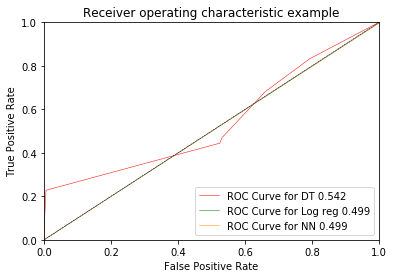

In [213]:
import matplotlib.pyplot as plt

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 5.1 Ensemble modelling

In [214]:
# import the model
from sklearn.ensemble import VotingClassifier

# initialise the classifier with 3 different estimators
voting = VotingClassifier(estimators=[('dt', dt_model), ('lr', log_reg_model), ('nn', nn_model)], voting='soft')

In [215]:
# fit the voting classifier to training data
voting.fit(X_train, y_train)

# evaluate train and test accuracy
print("Ensemble train accuracy:", voting.score(X_train, y_train))
print("Ensemble test accuracy:", voting.score(X_test, y_test))

# evaluate ROC auc score
y_pred_proba_ensemble = voting.predict_proba(X_test)
roc_index_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble[:, 1])
print("ROC score of voting classifier:", roc_index_ensemble)

C:\Users\JDH67\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Ensemble train accuracy: 0.8704921985327042
Ensemble test accuracy: 0.8705296150446034
ROC score of voting classifier: 0.7464413325301404


### a. Does the Ensemble model outperform the underlying models? Resonate your answer.

The ensemble model is almost the same as underlying models.but it fit very well and there is no sign of overfitting.

# Task6 Decision Making

## 1.Finally, based on all models and analysis, is there a particular model you will use in decision making? Justify your choice. 

We will use the decision tree model which tuned by grid cv since it provides the highest accuracy and fastest implement speed

## 2. Can you summarise positives and negatives of each predictive modelling method based on this analysis?

The NN need more training time cause it has more hyper-params and takes time for searching params. The logistic regression model need more time as well. The decision tree and NN have some overfitting problem, and they use the ensemble model for detection.

## 3.How the outcome of this study can be used by decision makers? 

These report can be given to second hand car dealer and help them figure out is a car kick or not .This is really important to thenm for minimizing the loss